In [1]:
using Revise
using LinearAlgebra
using MatrixMarket
using EAMC
using SparseArrays
using Plots
using Interact

┌ Info: Precompiling Revise [295af30f-e4ad-537b-8983-00126c2a3abe]
└ @ Base loading.jl:1273
┌ Info: Precompiling EAMC [d0d32b4c-83b1-4490-9109-c03fdd3b1e42]
└ @ Base loading.jl:1273
┌ Info: Precompiling Interact [c601a237-2ae4-5e1e-952c-7a85b0c7eef1]
└ @ Base loading.jl:1273


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-5889149917236016050\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-18297674727106902135\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-5889149917236016050\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
## load data
using MatrixMarket
data = cd("data/natalia191219") do 
    map(MatrixMarket.mmread, readdir())
end;

In [3]:
## adjust diagonal to be a proper q matrix
using LinearAlgebra
qs = data
qs = map(qs) do q
    q = q
    q .- Diagonal(sum(q, dims=2)|>vec) # mass conservation
end;

In [4]:
## galerkin discretization of the eamc
using EAMC
dt = ones(length(qs))
dt[end] = 1000
tmax = length(qs)
g = @time EAMC.galerkin(qs[1:tmax], dt[1:tmax]);

  4.805775 seconds (4.47 M allocations: 4.780 GiB, 14.96% gc time)


In [5]:
## create commitor systems

using SparseArrays
TT = g - I
nm = size(TT, 1)
n = 900
bnd = nm - n
for i in bnd+1 : nm
    TT[i,:] .= 0
    TT[i,i] = 1
end

In [6]:
## create commitor terminal condition
term = spzeros(nm,n)
term[nm-n+1:end, :] = sparse(I, n,n);

In [7]:
## solve commitors

@time cs = TT\collect(term)

 18.362978 seconds (4.82 M allocations: 1.687 GiB, 1.19% gc time)


21600×900 Array{Float64,2}:
 0.272127  0.141296  0.084313   0.0568949  …  6.94756e-57  1.22616e-58  -0.0
 0.27212   0.141248  0.0842731  0.0568633     7.83316e-57  1.38237e-58  -0.0
 0.272112  0.141188  0.0842237  0.0568239     8.99743e-57  1.58773e-58  -0.0
 0.272103  0.141131  0.0841766  0.0567865     1.05406e-56  1.85987e-58  -0.0
 0.272092  0.141071  0.0841273  0.0567473     1.28136e-56  2.26069e-58   0.0
 0.27208   0.141014  0.0840799  0.0567097  …  1.61445e-56  2.84798e-58  -0.0
 0.272066  0.140964  0.0840394  0.0566775     2.12208e-56  3.74291e-58   0.0
 0.272049  0.140931  0.084014   0.0566576     2.93775e-56  5.18079e-58   0.0
 0.272024  0.140916  0.0840043  0.0566504     4.30319e-56  7.58767e-58   0.0
 0.271984  0.140897  0.0839922  0.0566416     6.45676e-56  1.13837e-57  -0.0
 0.271919  0.140847  0.0839579  0.0566158  …  9.85115e-56  1.73669e-57   0.0
 0.271769  0.140632  0.083795   0.0564897     9.1882e-56   1.62038e-57  -0.0
 0.271368  0.14004   0.0833441  0.0561412     6.

In [8]:
cc = reshape(cs, 30, 30, 24, 30, 30)

30×30×24×30×30 Array{Float64,5}:
[:, :, 1, 1, 1] =
 0.272127    0.272127    0.272128    …  0.292792  0.287789  0.279424
 0.27212     0.27212     0.272122       0.276853  0.276493  0.271661
 0.272112    0.272112    0.272115       0.231766  0.245149  0.24695 
 0.272103    0.272104    0.272108       0.190882  0.210255  0.218698
 0.272092    0.272095    0.272102       0.176237  0.184063  0.193016
 0.27208     0.272086    0.272098    …  0.172067  0.17063   0.173894
 0.272066    0.27208     0.272101       0.176759  0.167642  0.167817
 0.272049    0.272081    0.272111       0.187128  0.176698  0.173479
 0.272024    0.272092    0.272125       0.198424  0.188586  0.183459
 0.271984    0.272105    0.272139       0.207126  0.198097  0.191516
 0.271919    0.272096    0.272141    …  0.212657  0.204849  0.197215
 0.271769    0.272043    0.272134       0.215964  0.209828  0.202298
 0.271368    0.271853    0.272096       0.218019  0.213015  0.205701
 ⋮                                   ⋱              

In [9]:
using Plots
@manipulate for x=slider(1:30, 15, label="x"), y=slider(1:30, 15, label="y"), t=slider(1:24, 1, label="t")
heatmap(cc[:,:,t,y,x], title="Commitor von (x=$x,y=$y,t=24) zum zeitpunkt t=$t")
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["x"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 30,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
15, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/alex/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000013d120010, Task (runnable) @0x000000013d120010), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":15,\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"16652798318001762468\",\"id\":\"ob_02\",\"type\":\"observable\"}),\"index\":WebIO.getval({\"name\":\"index\",\"scope\":\"16652798318001762468\",\"id\":\"ob_01\",\"type\":\"observable\"})};\n  

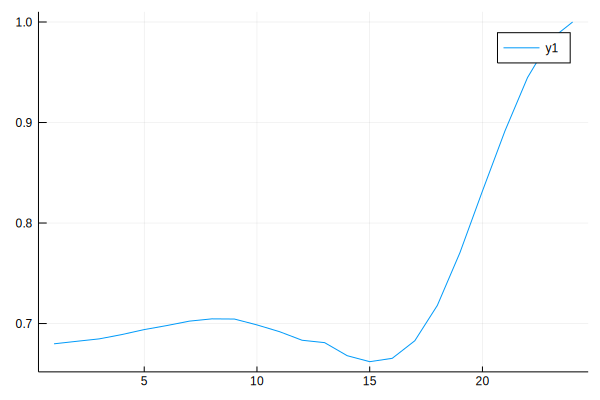

In [10]:
## starting with uniformly distributed mass at time t, how much of that mass is retained until t=24
# q: is this interpretation correct?
# a: i guess so, were losing mass since some rates are 0

plot([sum(cc[:,:,t,:,:])/900 for t=1:24])

In [11]:
## restrict clustering area to the center
tcluster = 15 # timepoint at which to seperate the clusters
xmin, xmax, ymin, ymax = 6,25,6,25
M = reshape(cc[xmin:xmax, ymin:ymax, tcluster, xmin:xmax, ymin:ymax], 20*20*1, 20*20)
#css = css ./ sqrt.(sum(css, dims=1))
#M = reshape(cc[:,:,12,:,:], 30*30, 30*30)

M = M' * M
M = M - Diagonal(M)
M = M ./ sum(M, dims=2)

400×400 Array{Float64,2}:
 0.0         0.0362726   0.0289108   0.0143726   …  1.50493e-12  1.19088e-12
 0.0345273   0.0         0.0240094   0.0121456      1.57403e-12  1.24596e-12
 0.0255141   0.0222596   0.0         0.00948266     1.66149e-12  1.3157e-12 
 0.0167626   0.0148813   0.0125319   0.0            1.74731e-12  1.38417e-12
 0.0117618   0.0106697   0.00928923  0.00531743     1.80538e-12  1.43044e-12
 0.0100464   0.00924088  0.00820973  0.00483371  …  1.82902e-12  1.44924e-12
 0.0112291   0.0103077   0.00912     0.0053309      1.82204e-12  1.44352e-12
 0.0125132   0.0114663   0.0101096   0.0058725      1.81797e-12  1.44008e-12
 0.0137906   0.0126221   0.0111009   0.0064185      1.81876e-12  1.44047e-12
 0.0156773   0.0143255   0.0125578   0.00721801     1.82028e-12  1.44132e-12
 0.0166948   0.0152564   0.0133692   0.00767594  …  1.83337e-12  1.45142e-12
 0.0169742   0.0155301   0.0136307   0.00784215     1.85813e-12  1.47084e-12
 0.0165108   0.015141    0.0133353   0.00771129   

In [12]:
include("src/pccap.jl")
nc = 4
p = pccap(M, nc)
# now sort by cluster size
p = p[:,sortperm(sum(p, dims=1)|>vec, rev=true)]

400×4 Array{Float64,2}:
  0.998803     1.53012e-15  9.87897e-16  0.00119675 
 -1.19252e-15  0.460462     0.278103     0.261435   
  0.316368     0.332873     0.204829     0.14593    
  0.376944     0.324332     0.20267      0.0960531  
  0.390522     0.3318       0.208886     0.0687922  
  0.39475      0.334509     0.211115     0.0596262  
  0.395426     0.329142     0.207337     0.0680955  
  0.396139     0.323296     0.203302     0.0772633  
  0.396961     0.317292     0.199295     0.0864521  
  0.397635     0.309075     0.19383      0.0994601  
  0.398681     0.303651     0.190647     0.107021   
  0.400224     0.300319     0.189232     0.110226   
  0.402098     0.299206     0.189645     0.10905    
  ⋮                                                 
  0.393221     0.377754     0.228578     0.000447296
  0.393211     0.377575     0.228784     0.00043053 
  0.393227     0.377932     0.228385     0.000455161
  0.393253     0.377819     0.228454     0.000474373
  0.393282     0.37722

In [13]:
cl = reshape(cc[:,:,:, xmin:xmax, ymin:ymax], 30*30*24, 20*20) * p
cl = reshape(cl, 30, 30, 24, nc)

30×30×24×4 Array{Float64,4}:
[:, :, 1, 1] =
 0.000210766  0.000210767  0.000210734  …  0.00010669  7.93415e-5 
 0.000211053  0.00021105   0.000210991     0.00123644  0.000813581
 0.000211412  0.000211398  0.00021129      0.00545941  0.00377728 
 0.000211768  0.000211728  0.000211548     0.00961815  0.00656    
 0.000212161  0.000212058  0.000211783     0.0120556   0.00851276 
 0.000212573  0.000212365  0.000211912  …  0.0137029   0.0102909  
 0.00021299   0.000212544  0.000211797     0.0151893   0.01248    
 0.000213391  0.000212461  0.000211439     0.016615    0.0149061  
 0.000213835  0.000212162  0.000211062     0.0165763   0.0158822  
 0.000214504  0.000211925  0.000210922     0.015888    0.0158868  
 0.000215648  0.000212423  0.000211877  …  0.0149531   0.0154392  
 0.000218334  0.000213816  0.000212259     0.0140962   0.0148591  
 0.000224967  0.000218005  0.000213723     0.0134506   0.0143469  
 ⋮                                      ⋱                         
 0.000400353  0.00

In [14]:
using Interact
c = 3
gr()
@manipulate for i = 1:24, c=1:nc
heatmap(log.(cl[:,:,i,c].+1), title="pccap on center, t=$i", clims=(0,.3))
    end

@manipulate for i = 1:24, c=1:nc
heatmap(cl[:,:,i,c], title="pccap on center, t=$i")
    end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["i"], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 24,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Int64} with 2 listeners. Value:
12, nothing)), Set(String[]), nothing, Asset[Asset("js", "knockout", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/alex/.julia/packages/Knockout/1sDlc/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/all.js"), Asset("css", nothing, "/Users/alex/.julia/packages/InteractBase/9mFwe/src/../assets/style.css"), Asset("css", nothing, "/Users/alex/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set(AbstractConnection[]), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x000000013cbf3cd0, Task (runnable) @0x000000013cbf3cd0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\"],\"changes\":WebIO.getval({\"name\":\"changes\",\"scope\":\"9214994919676905556\",\"id\":\"ob_